# 1. Imports

In [1]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm, gamma
from scipy import interpolate, optimize, integrate

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import itertools
import time

from W_Stress import W_Stress
from helper import create_u_grid

In [2]:
from IPython.display import display

In [3]:
# Set random seed
np.random.seed(1)

# 2. Generating Data - The Baseline Model

We consider a spatial model for modelling insurance portfolio losses, where each individual loss occurs at different locations and the dependence between individual losses is a function of the distance between the locations of the losses. 

The locations $z_m = (z^1_m, z^2_m)$ for $m = 1, ..., 10$ are randomly selected, where $z^i_m \sim Unif(0,1)$ for $i=1,2$. The insurance loss at location $m$, denoted by $L_m$, follows a $Gamma(5, 0.2m)$ distribution with location parameter $25$. The losses $L_1, ..., L_m$ have, conditionally on $\Theta = \theta$, a Gaussian copula with correlation matrix $\Omega$ given by $\rho_{i,j} =$ Cor$(L_i,L_j) = e^{-\theta \lVert z_i - z_j \lVert}$, where Euclidean distance. The parameter $\Theta$ takes values (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35),corresponding to different regimes. 

Lastly, we calculate the total loss of the insurance company by $Y = \sum_{m=1}^{10} L_m$.

In [4]:
def generate_spatial_data(Nsims, plot=True):
    # Get z1, ... , z10 where zi = (zi(1), zi(2)) and zi(1), zi(2) ~ U(0,1)
    z1 = np.random.uniform(size=10)
    z2 = np.random.uniform(size=10)
    z = list(zip(z1, z2))

    # Get theta in (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35)
    x = np.random.uniform(0, 1, size=Nsims)
    thetas = np.zeros(Nsims)

    thetas[np.where(x <= 0.05)] = 0
    thetas[np.where((0.05 < x) & (x <= 0.65))] = 0.4
    thetas[np.where(x > 0.65)] = 5

    # Generate realizations of (L1, ..., L10) using Gaussian copulas
    x = np.zeros((Nsims, 10))
    theta_labels = {5:[], 0.4:[], 0: []}
    for i in range(Nsims):
        theta = thetas[i]
        # Get the correlation
        # rho_ij = exp{-theta_i * ||zi - zj||} where ||.|| denotes the Euclidean distance
        Omega = np.zeros((10, 10))
        for j in range(10):
            for k in range(10):
                Omega[j, k] = np.exp(-theta * np.linalg.norm(np.array(z[j]) - np.array(z[k])))

        # Create samples from a correlated multivariate normal
        x0 = np.random.multivariate_normal(mean=np.zeros(10), cov=Omega)
        x[i, :] = x0
        theta_labels[theta].append(i)

    # Get uniform marginals
    u = norm.cdf(x)

    # Marginal distributions Li ~ Gamma(5, 0.2i) with mean=25
    L = np.zeros((Nsims, 10))
    x_axis = np.linspace(25, 50, 200)
    means = np.zeros(10)
    for i in range(10):
        L_i = gamma.ppf(u[:, i], a=5, loc=25, scale=0.2*(i+1))
        L[:, i] = L_i

        means[i] = np.mean(L_i)

        # Gamma distribution plot
        if plot:
            y_i = gamma.pdf(x_axis, a=5, loc=25, scale=0.2*(i+1))
            plt.plot(x_axis, y_i, label=f"scale={0.2*(i+1)}")
    if plot:
        plt.legend()
        plt.savefig('Plots/ex/data_marginal_dist.pdf', format='pdf')
        plt.show()

    max_mean = np.max(means)
    min_mean = np.min(means)
    marker_sizes = (means - min_mean)/(max_mean - min_mean)*150

    # Location plot
    if plot:
        plt.scatter(z1, z2, marker='o', color='black', s=marker_sizes)
        plt.savefig('Plots/ex/data_location_by_mean.pdf', format='pdf')
        plt.show()

    # Define the data and get the bandwidths, density and CDF
    data = {"y": np.sum(L, axis=1), "x": L}

    return data, theta_labels

# 3. Calculating Stressed Models

### 3a. Setup the W_Stress Model

In [5]:
# Define the gridspace
u = create_u_grid([0.005, 0.95])

# Generate data (spatial)
data, theta_labels = generate_spatial_data(1000, plot=False)
brackets = [200, 450]
folder = 'Plots/ex/'

In [6]:
# Generate the model
StressModel = W_Stress(data, u, brackets)

### 3b. Example: Stress alpha-beta risk measure

In [7]:
# set alpha, beta, p levels
p_list = [0.25, 0.5, 0.75]
alpha = 0.9
beta = 0.1

# Set stresses
ES_stresses = [[0, 1], [5, 5]]

# Set (Li, Lj) to plot
i = 1
j = 8

# Initialize sensitivity results lists
sensitivity_measures = []
labels = []
colors = ['blue', 'red', 'green']

#### The alpha-beta Risk Measure

The $\alpha-\beta$ risk measure, $0 < \beta \leq \alpha < 1$, is defined by $\gamma(u) = \frac{1}{\eta}(p\mathbb{1}_{\{u < \beta\}} + (1-p)\mathbb{1}_{\{u \geq \alpha\}})$ for $p \in [0, 1]$ and $\eta = p \beta + (1-p)(1-\alpha)$.

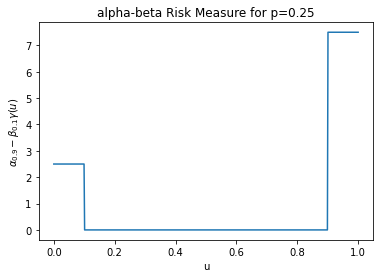

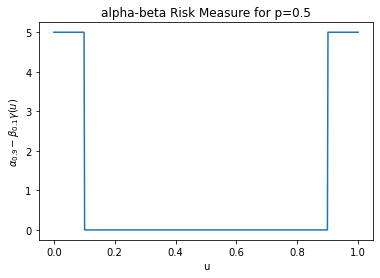

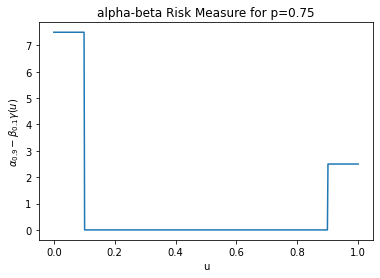

In [8]:
for p in p_list:
    # Set the alpha-beta gamma function and plot
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]
    StressModel.set_gamma(alpha_beta_gamma)
    
    plt.plot(u, alpha_beta_gamma[0](u))
    plt.ylabel(r'$\alpha_{0.9}-\beta_{0.1} \gamma(u)$')
    plt.xlabel('u')
    plt.title(f'alpha-beta Risk Measure for p={p}')
    plt.show()

#### The Stressed Distribution


lambda =  [5.34526064]
 WD =  13.202310743965729
 Risk Measure =  [360.7102975]
 Target Risk Measure =  [360.71028952]
 Base Risk Measure =  [327.91844502]




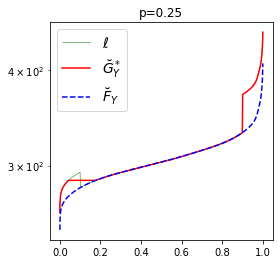

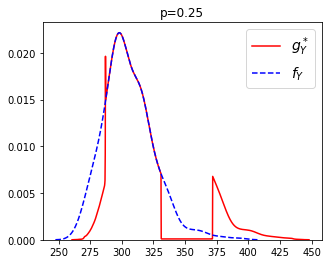

lambda =  [7.70441245]
 WD =  15.028926243712563
 Risk Measure =  [340.77474972]
 Target Risk Measure =  [340.7747423]
 Base Risk Measure =  [309.79522027]




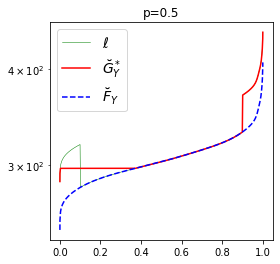

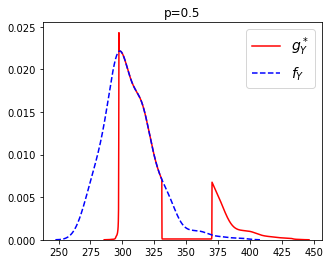

lambda =  [7.68154905]
 WD =  15.044295905624613
 Risk Measure =  [320.86490676]
 Target Risk Measure =  [320.86489382]
 Base Risk Measure =  [291.69535802]




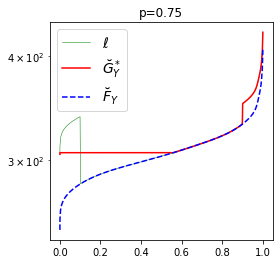

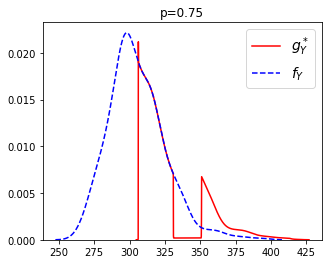

In [9]:
# Run optimization
for p in p_list:
    # Set the alpha-beta gamma function
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]
    StressModel.set_gamma(alpha_beta_gamma)

    # compute the baseline risk-measure of the base model
    RM_P = StressModel.get_risk_measure_baseline()
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1.1]), title=f"p={p}")

    # Generate filename
    filename = folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_p_{p}_10'
    
    # Plot quantile functions
    display(fig)
    # fig.savefig(filename + '_inv.pdf', format='pdf')

    # Plot result distributions
    StressModel.plot_dist(filename, type="ES", title=f"p={p}", cdf=False, save=False)

#### The Stressed Model

lambda =  [5.34525508]
 WD =  13.202297157815964
 Risk Measure =  [360.71026395]
 Target Risk Measure =  [360.71028952]
 Base Risk Measure =  [327.91844502]




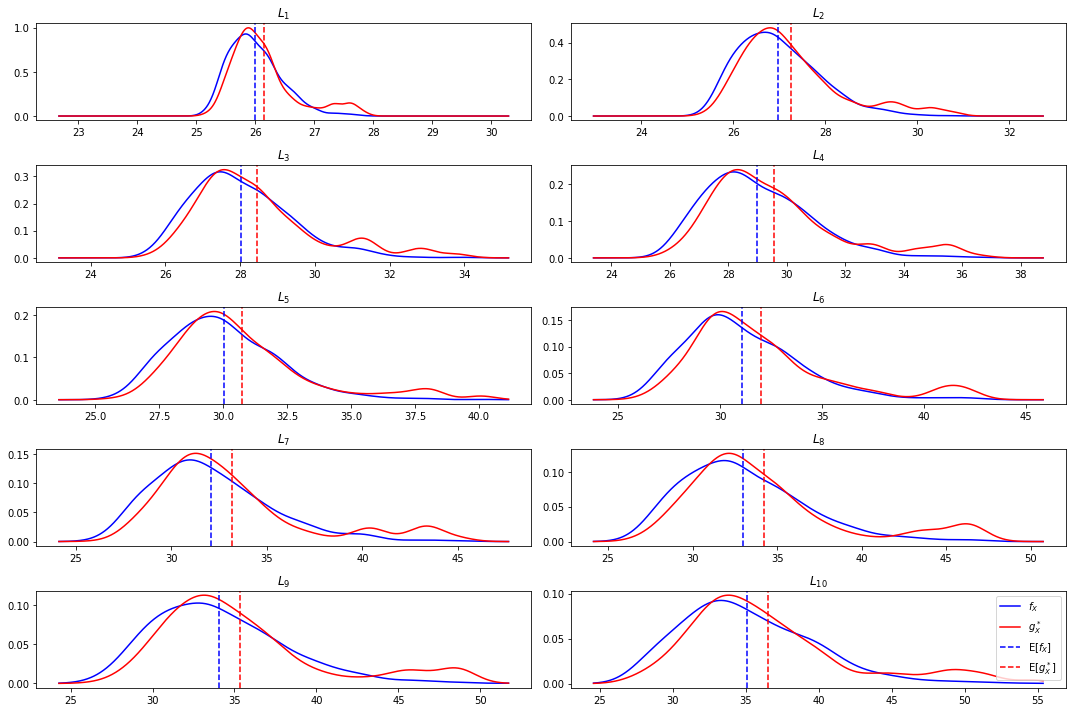

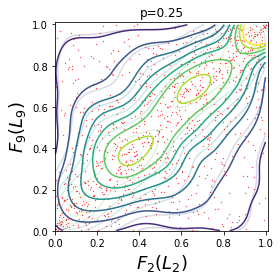

lambda =  [7.70440966]
 WD =  15.028920499538312
 Risk Measure =  [340.77473894]
 Target Risk Measure =  [340.7747423]
 Base Risk Measure =  [309.79522027]




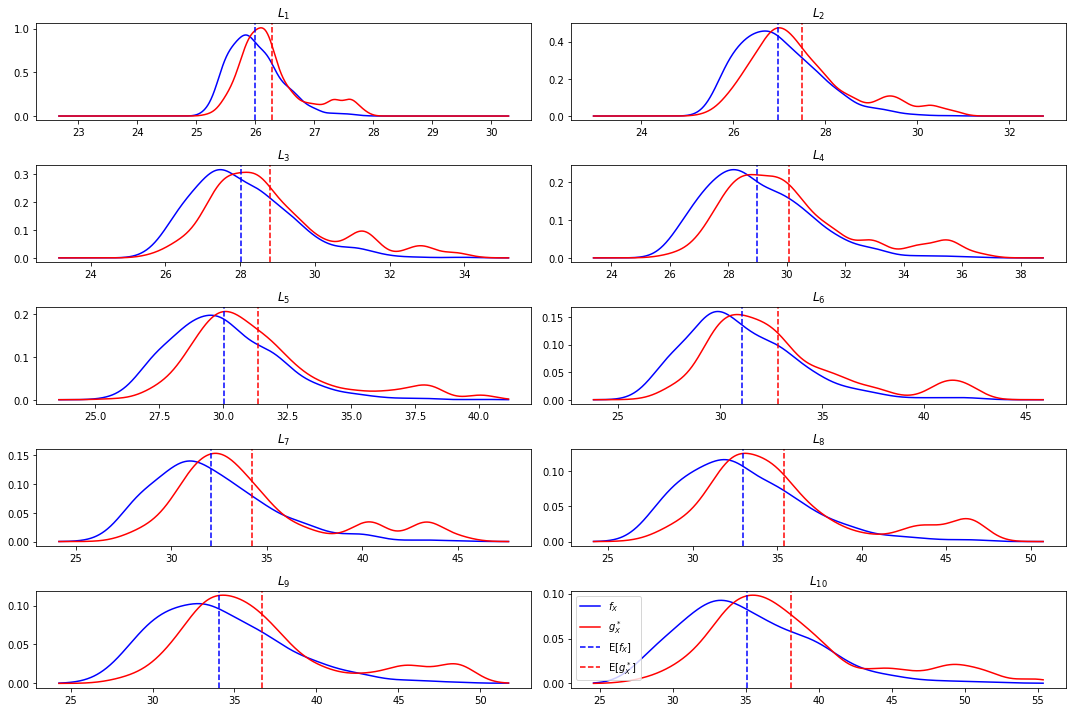

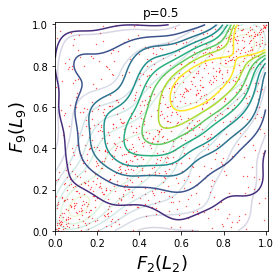

lambda =  [7.68154898]
 WD =  15.044295757589554
 Risk Measure =  [320.86490655]
 Target Risk Measure =  [320.86489382]
 Base Risk Measure =  [291.69535802]




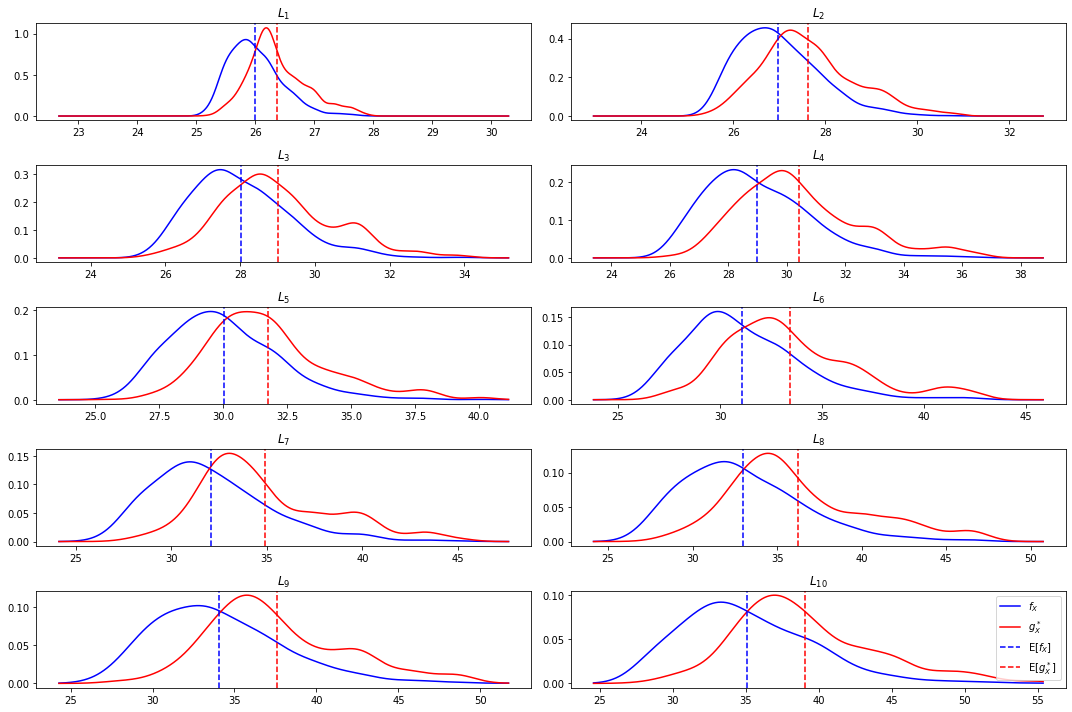

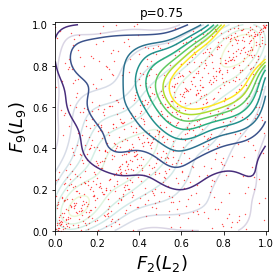

In [10]:
# Run optimization
for p in p_list:
    # Set the alpha-beta gamma function
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]
    StressModel.set_gamma(alpha_beta_gamma)

    # compute the baseline risk-measure of the base model
    RM_P = StressModel.get_risk_measure_baseline()
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1.1]), title=f"p={p}")

    # Generate filename
    filename = folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_p_{p}_10'
    # fig.savefig(filename + '_inv.pdf', format='pdf')
      
    # Plot density of Li
    StressModel.plot_xdensity(filename, save=False)
    
    # Plot copula contours for selected (Li, Lj)
    StressModel.plot_copula(i, j, filename + f'_copula_L{i}_L{j}.pdf',
                            save=False, title=f'p={p}')

    # Calculate sensitivity_measures
    sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
    labels.append(f'p={p}')

#### Sensitivity Measures
For a function $s: \mathbb{R} \to \mathbb{R}$, the reverse sensitivity measure to input $X_i$ with respect to a stressed probability measure $\mathbb{Q}^*$ is defined by

\begin{align}
S_i^{\mathbb{Q}^*} &= \frac{\mathbb{E}^{\mathbb{Q}^*}[s(X_i)] - \mathbb{E}[s(X_i)]}{\max_{\mathbb{Q} \in Q}\mathbb{E}^{\mathbb{Q}}[s(X_i)] - \mathbb{E}[s(X_i)]} \quad \quad & \mathbb{E}^{\mathbb{Q}^*}[s(X_i)] \geq \mathbb{E}[s(X_i)] \\
&= -\frac{\mathbb{E}^{\mathbb{Q}^*}[s(X_i)] - \mathbb{E}[s(X_i)]}{\min_{\mathbb{Q} \in Q}\mathbb{E}^{\mathbb{Q}}[s(X_i)] - \mathbb{E}[s(X_i)]} & otherwise
\end{align}

where Q = {$\mathbb{Q}$ | $\mathbb{Q}$ probability measure with $\frac{d\mathbb{Q}}{d\mathbb{P}} \stackrel{\mathbb{P}}{=} \frac{d\mathbb{Q}^*}{d\mathbb{P}}$} is the set of all probability measures whose RN-derivative have the same distribution as $\frac{d\mathbb{Q}^*}{d\mathbb{P}}$ under $\mathbb{P}$.

We use $s(X_i) = X_i$.

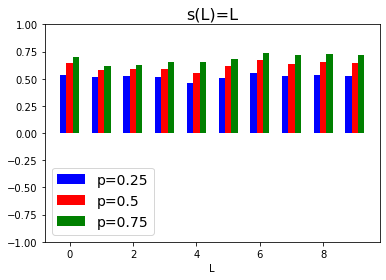

In [11]:
# Plot sensitivity measure
StressModel.plot_sensitivities(sensitivity_measures, folder +
                               f'alpha-beta/data_alpha_{alpha}_beta_{beta}_10_sensitivity.pdf',
                               colors, labels, title='s(L)=L', save=False)

### 3c. Example: Stress HARA utility + ES risk measure

In [ ]:
# Define hara parameters
a = 1
eta = 0.5
hara = lambda a, b, eta, x: (1 - eta) / eta * (a * x / (1 - eta) + b) ** eta
b = lambda eta: 5 * (eta / (1 - eta)) ** (1 / eta)

# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]
StressModel.set_gamma(gammas)

# Set stresses
utility_stresses = [0, 1]
rm_stresses = [[0, 1], [1, 3]]

# Set (Li, Lj) to plot
i = 1
j = 8

# Initialize sensitivity results lists
sensitivity_measures1 = []
sensitivity_measures2 = []
sensitivity_measures3 = []
labels = []
colors = ['pink', 'purple', 'blue']

# Run optimization
# Get baseline risk measure and utility to be stressed
RM_P = StressModel.get_risk_measure_baseline()
Utility_P = StressModel.get_hara_utility(a, b(eta), eta, StressModel.u, StressModel.F_inv)

# Plot baseline copulas for selected (Li, Lj)
StressModel.plot_copula_baseline(i, j, folder + f'hara-es/copula/data', save=False)

# Run each stress
for i in range(len(utility_stresses)):
    utility_stress = utility_stresses[i]
    rm_stress = rm_stresses[i]

    _, _, _, fig = StressModel.optimise_HARA(a, b(eta), eta, Utility_P * (1 + utility_stress / 100),
                                             RM_P * np.array([1 + rm_stress[0] / 100, 1 + rm_stress[1] / 100]))

    # Generate filename
    filename = folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}'
    # fig.savefig(filename + '_inv.pdf', format='pdf')

    # Plot result distributions
    StressModel.plot_dist(filename, type="Utility", save=False)
    
    # Plot density of Li
    StressModel.plot_xdensity(filename, save=False)

    # Plot copula contours for selected (Li, Lj)
    StressModel.plot_copula(i, j, folder + f'hara-es/copula/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}',
                            save=False, title=f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')

    # Calculate sensitivity_measures
    S1 = np.zeros(10)
    S2 = np.zeros(10)
    for k in range(10):
        # Get s:R->R
        level1 = 0.95
        level2 = 0.8
        s1 = lambda x: x > gamma.ppf(level1, a=5, loc=25, scale=0.2 * (k + 1))
        s2 = lambda x: x > gamma.ppf(level2, a=5, loc=25, scale=0.2 * (k + 1))
        S1[k] = StressModel.reverse_sensitivity_measure(s1, StressModel.data['x'][:, k])
        S2[k] = StressModel.reverse_sensitivity_measure(s2, StressModel.data['x'][:, k])
    S3 = StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])

    sensitivity_measures1.append(S1)
    sensitivity_measures2.append(S2)
    sensitivity_measures3.append(S3)

    labels.append(f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')

# Plot sensitivities
StressModel.plot_sensitivities(sensitivity_measures1, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.95)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_95.pdf')
StressModel.plot_sensitivities(sensitivity_measures2, labels=labels, colors=colors,
                           title=r's($L_i$) = I{$L_i > \breve{F_i}(0.8)$}', save=False,
                           filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_80.pdf')
StressModel.plot_sensitivities(sensitivity_measures3, labels=labels, colors=colors,
                           title=r's($L_i$) = $L_i$', save=False,
                           filename=folder + f'hara-es/data_ES_utility_sensitivity.pdf')